# Neural Networks: Part 2 - Data Prep

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset Preparation

So far, we have also dealt with pre-processed datasets. Preparing data for machine learning is usualy more time consuming than actually developing and training models, so let's start with a little rougher dataset. Load in the wages dataset that describes characteristics of a group of individuals. We will build a model that takes in demographic info and predicts whether an individual has health insurance.

In [2]:
import pandas as pd

df = pd.read_csv('data/wages.csv')
print(len(df))
df.head(5)

3000


,index,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,wage
0,0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,75.043154
1,1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,70.476020
2,2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,130.982177
3,3,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,154.685293
4,4,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,75.043154


Its apparent we have a mix of categorical and numeric data. Each type of data requires a different method to prepare it.

- Categorical: use *one hot encoding*
- Numeric: if it is logarithmically distributed, take the log of the data, then standardize to a mean of 0 and standard deviation of 1

However, before processing the data, we have to ask ourselves an important question.

Do we, as humans, expect all these features to be relevant for predicting health insurance? What are the ethical considerations of including this data?

Because we don't want to introduce a racial bias to our model, we will drop race as an input feature. The other features seem potentially relevant for our task at hand.

In [3]:
# check the type of data in each column
df = df.drop('race', axis=1)
print(df.dtypes)

index           int64
year            int64
age             int64
sex            object
maritl         object
education      object
region         object
jobclass       object
health         object
health_ins     object
wage          float64
dtype: object


### Numeric data

We will examine the distribution of each feature, and determine the best way to transform it into a "numerically stable" region, aka centered about 0 and scaled roughly with a standard deviation of 1. This ensures that features are treated similarly by the network, and will promote numerical stability during training.

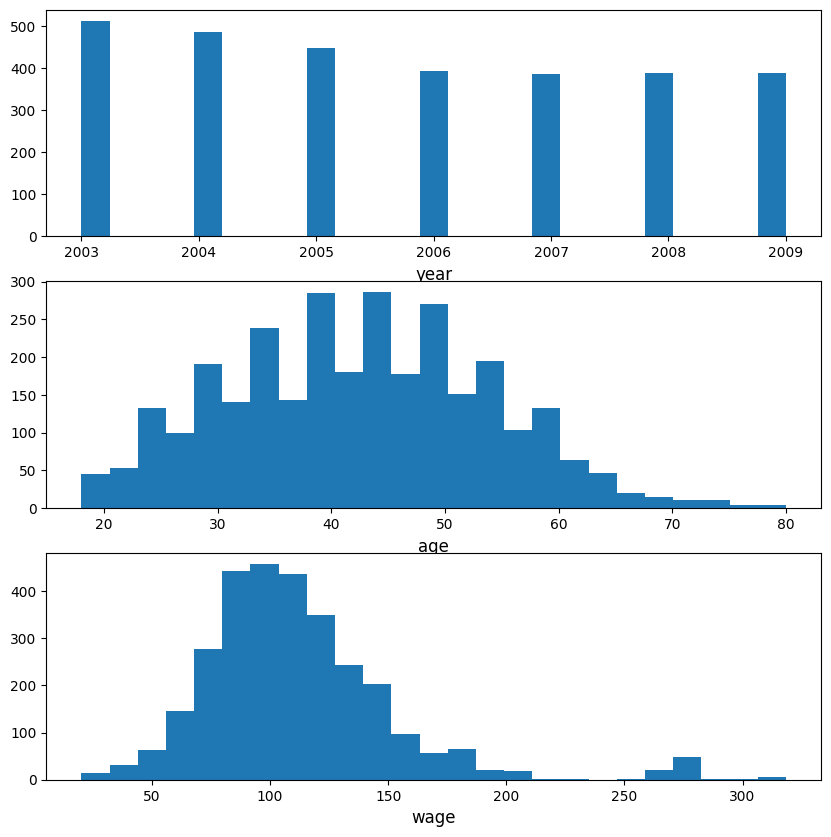

In [4]:
# use that information to visualize the distribution of data for each numeric column
numeric_columns = ["year","age","wage"]
fig, axs = plt.subplots(3,1, figsize=(10,10))
for i in range(3):
    axs[i].hist(df[numeric_columns[i]], bins = 25)
    axs[i].set_xlabel(numeric_columns[i], fontsize = 12)

In [5]:
# let's write a function that standardizes numeric data that we can apply to our dataframe
def standardize_numeric(series: pd.Series, use_log: bool = False) -> pd.Series:
    # write code here that optionally takes the log of in the input series, then standardizes it
    if use_log:
        series = np.log(series)
    series = (series - np.mean(series)) / np.std(series)
    return series

df['year_st'] = standardize_numeric(df['year'], False)
df['age_st'] = standardize_numeric(df['age'], False)
df['wage_st'] = standardize_numeric(df['wage'], True)

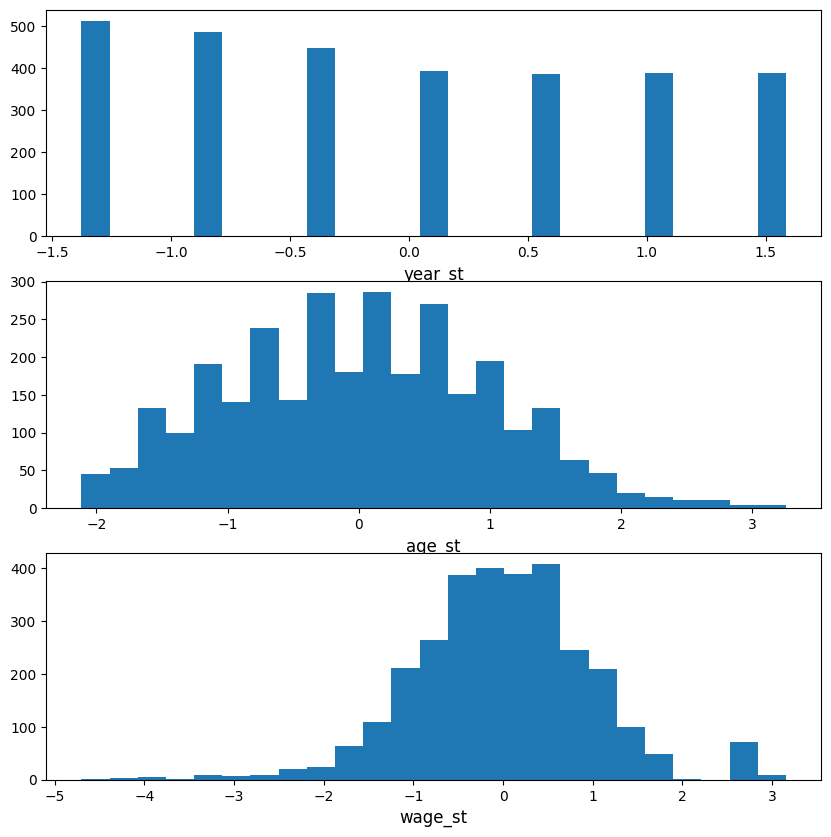

In [6]:
# visualize transformed numeric data
numeric_columns = ["year_st","age_st","wage_st"]
fig, axs = plt.subplots(3,1, figsize=(10,10))
for i in range(3):
    axs[i].hist(df[numeric_columns[i]], bins = 25)
    axs[i].set_xlabel(numeric_columns[i], fontsize = 12)

### Categorical data

We will identify the potential classes for each column, and then one-hot encode them. One-hot encoding entails representing classes as an integer encoding. For instance, given 3 possible labels of [ `Healthy`, `Sick`, `Unknown` ], say we have a data sample where an individual is labeled as 'Sick'. We can encode it like this

        [0, 1, 0]

Where each value represents a class. '1' means the class is labelled as true for that entry. Technically, you can have multiple 1s in a single encoding, thus meaning it is a *multi-label* task, or that your classes are not mutually exclusive. In the scenario above, our classes are mutually exclusive, thus we can expect only a single 1.

In [7]:
# check the type of data in each column
print(df.dtypes)

index           int64
year            int64
age             int64
sex            object
maritl         object
education      object
region         object
jobclass       object
health         object
health_ins     object
wage          float64
year_st       float64
age_st        float64
wage_st       float64
dtype: object


In [8]:
# look at all labels for each column, and the number of appearances of each
categoric_columns = ['sex','maritl','education','region','jobclass','health','health_ins']
for i in range(len(categoric_columns)):
    print(f"\nColumn: {categoric_columns[i]}")
    counts = df[categoric_columns[i]].value_counts()
    for label, count in counts.items():
        print(f"Label: '{label}' | Frequency: {count}")


Column: sex
Label: '1. Male' | Frequency: 3000

Column: maritl
Label: '2. Married' | Frequency: 2074
Label: '1. Never Married' | Frequency: 648
Label: '4. Divorced' | Frequency: 204
Label: '5. Separated' | Frequency: 55
Label: '3. Widowed' | Frequency: 19

Column: education
Label: '2. HS Grad' | Frequency: 971
Label: '4. College Grad' | Frequency: 685
Label: '3. Some College' | Frequency: 650
Label: '5. Advanced Degree' | Frequency: 426
Label: '1. < HS Grad' | Frequency: 268

Column: region
Label: '2. Middle Atlantic' | Frequency: 3000

Column: jobclass
Label: '1. Industrial' | Frequency: 1544
Label: '2. Information' | Frequency: 1456

Column: health
Label: '2. >=Very Good' | Frequency: 2142
Label: '1. <=Good' | Frequency: 858

Column: health_ins
Label: '1. Yes' | Frequency: 2083
Label: '2. No' | Frequency: 917


Should we keep all these columns? Why or why not?

Are any of these features more **ordinal** in nature? As in, you could place each label on an axis of some kind and assign a value to it?

Are any of our labels particularly imbalanced? Why is that potentially a bad thing and what would you do to fix it?

In [9]:
# drop any columns you decide are not good to keep
df = df.drop(['sex','region'], axis=1)

Now, one-hot encode the categorical data

In [10]:
# this code efficiently converts labels in columns into columns themselves, then populates it with 1s and 0s accordingly
keep_categoric_columns = ['maritl','education','jobclass','health','health_ins']
for col in keep_categoric_columns:
    df = df.join(pd.get_dummies(df[col], dtype='int'), how = 'outer')
df.head(10)

,index,year,age,maritl,education,jobclass,health,health_ins,wage,year_st,...,2. HS Grad,3. Some College,4. College Grad,5. Advanced Degree,1. Industrial,2. Information,1. <=Good,2. >=Very Good,1. Yes,2. No
0,0,2006,18,1. Never Married,1. < HS Grad,1. Industrial,1. <=Good,2. No,75.043154,0.103168,...,0,0,0,0,1,0,1,0,0,1
1,1,2004,24,1. Never Married,4. College Grad,2. Information,2. >=Very Good,2. No,70.476020,-0.884082,...,0,0,1,0,0,1,0,1,0,1
2,2,2003,45,2. Married,3. Some College,1. Industrial,1. <=Good,1. Yes,130.982177,-1.377707,...,0,1,0,0,1,0,1,0,1,0
3,3,2003,43,2. Married,4. College Grad,2. Information,2. >=Very Good,1. Yes,154.685293,-1.377707,...,0,0,1,0,0,1,0,1,1,0
4,4,2005,50,4. Divorced,2. HS Grad,2. Information,1. <=Good,1. Yes,75.043154,-0.390457,...,1,0,0,0,0,1,1,0,1,0
5,5,2008,54,2. Married,4. College Grad,2. Information,2. >=Very Good,1. Yes,127.115744,1.090417,...,0,0,1,0,0,1,0,1,1,0
6,6,2009,44,2. Married,3. Some College,1. Industrial,2. >=Very Good,1. Yes,169.528538,1.584042,...,0,1,0,0,1,0,0,1,1,0
7,7,2008,30,1. Never Married,3. Some College,2. Information,1. <=Good,1. Yes,111.720849,1.090417,...,0,1,0,0,0,1,1,0,1,0
8,8,2006,41,1. Never Married,3. Some College,2. Information,2. >=Very Good,1. Yes,118.884359,0.103168,...,0,1,0,0,0,1,0,1,1,0
9,9,2004,52,2. Married,2. HS Grad,2. Information,2. >=Very Good,1. Yes,128.680488,-0.884082,...,1,0,0,0,0,1,0,1,1,0


### Conversion

The dataframe is processed, and now must simply be converted into a tensor for our ML model.

In [11]:
# list out all your finalized INPUT and OUTPUT feature columns.
features = ['year_st', 'age_st', 'wage_st',
       '1. Never Married', '2. Married', '3. Widowed', '4. Divorced',
       '5. Separated', '1. < HS Grad', '2. HS Grad', '3. Some College',
       '4. College Grad', '5. Advanced Degree', '1. Industrial',
       '2. Information', '1. <=Good', '2. >=Very Good']

# write down your TARGET columns
# Because our task is a binary classification task (has insurance, or doesn't), we can actually just represent the target 
# as a single vector of 0s and 1s, where 0 indicates no insurance, and 1 indicates possession of insurance.
target = ['1. Yes']

# create new dataframes of your inputs and outputs
train_df = df[features + target]

Now, we will split our data. However, due to the imbalance of our target class, we will do *stratified* splitting. That means we won't accidentally over-represent a certain class in one our splits due to random chance.

In [12]:
from sklearn.model_selection import train_test_split

# split train and val
x_train, x_val, y_train, y_val = train_test_split(train_df[features], train_df[target], train_size=0.6, stratify=train_df[target])

# split again to get a test set
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, train_size=0.5, stratify=y_val)

print("x train: ",x_train.shape, "y train:", y_train.shape)
print("x val: ",x_val.shape, "y train:", y_val.shape)
print("x test: ",x_test.shape, "y test:", y_test.shape)

x train:  (1800, 17) y train: (1800, 1)
x val:  (600, 17) y train: (600, 1)
x test:  (600, 17) y test: (600, 1)


And finally, let's convert our data into tensors, and save it to disk so we don't have to do this again!

In [13]:
# dataframes -> numpy arrays -> tensors
print(x_train)
x_train, x_val, x_test = torch.Tensor(x_train.to_numpy()), torch.Tensor(x_val.to_numpy()), torch.Tensor(x_test.to_numpy())
y_train, y_val, y_test = torch.Tensor(y_train.to_numpy()), torch.Tensor(y_val.to_numpy()), torch.Tensor(y_test.to_numpy())

# store it in a dict that we can save out as a single file
data_dict = {'x_train':x_train, 'x_val':x_val, 'x_test':x_test, 'y_train':y_train, 'y_val':y_val, 'y_test':y_test}

# save it to local data directory
torch.save(data_dict, 'data/wages_processed.pt')

       year_st    age_st   wage_st  1. Never Married  2. Married  3. Widowed  \
2315 -0.390457  0.483977 -1.310175                 0           1           0   
654   1.090417  1.350492  0.727308                 0           1           0   
2495 -0.390457 -1.075749 -0.147415                 0           1           0   
1318  1.584042 -1.335704 -0.752754                 0           1           0   
2461 -0.390457  1.783750  0.742073                 0           1           0   
...        ...       ...       ...               ...         ...         ...   
1087 -0.390457 -0.902446  0.311415                 0           1           0   
1042  0.596793 -1.509007 -1.400471                 1           0           0   
363  -0.390457 -0.469189 -0.502664                 0           0           1   
2803 -0.390457  0.657280  1.564471                 0           1           0   
733  -1.377707 -0.989098  1.101775                 0           0           0   

      4. Divorced  5. Separated  1. < H

In [14]:
# and confirm it works by loading it back in as a tensor
data_dict = torch.load('data/wages_processed.pt')
print(data_dict.keys())

dict_keys(['x_train', 'x_val', 'x_test', 'y_train', 'y_val', 'y_test'])


And we have completed data preparation! It can be a tedious procedure at times, but probably 80% of the time, the source of errors during training come from data preparation, so it is absolutely necessary to know exactly how your data was gathered out in the wild, how it was filtered and prepared, and how it was transformed for your ML model.